In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns

from __future__ import division
%matplotlib inline
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)


# Homework 4

$g(x|\theta) = w N(x | \mu_1, \sigma^2) + (1-w) N(x|\mu_2, \sigma^2)$

$\lambda=1/\sigma^2$ as GA(1,1)

$f(\mu_1)=N(0,100)$ and $f(\mu_2) = N(0,100)$

$f(w) = U(0,1)$

## 1.

First generate 100 samples from standard normal.

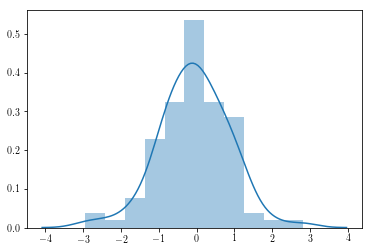

In [49]:
sample1 = []  #100 samples from standard normal distribution
for i in xrange(100):
    sample1.append(np.random.randn()) 
sns.distplot(sample1)
plt.show()

In [3]:
def gaussian(x, mu, lmbda):
    """
    compute probablity of Gaussian distribution with mean and inverse variance
    """
    return np.exp(-np.power(x - mu, 2.) * lmbda / 2 ) / np.sqrt(2*np.pi/lmbda)

Implementation of Gibbs sampler:

### i. conditional density for latent variable d:

    
    

\begin{equation}
    Pr(d_i = 1 | \theta, x_i) = \frac{w N(X_i | \mu_1, \sigma_1^2)}
                                     {w N(X_i | \mu_1, \sigma_1^2) + (1-w) N(X_i | \mu_2, \sigma_2^2)}
    \end{equation}

In [4]:
def draw_d(w, mu1, mu2, lmbda, x):
    """
    :type w: float
    :type x: np.array
    :type mu1: float
    :type mu2: float
    :type lmbda: float
    :rtype: np.array
    """
    d = np.ones(len(x)) #initialize all d to 1
    u = np.random.uniform(0,1,len(x)) #take u from U(0,1)
    p = w*(gaussian(x, mu1, lmbda))/(
        w*(gaussian(x, mu1, lmbda)) + (1-w)*(gaussian(x, mu2, lmbda))) #probablity of d=1
    d[u>p] = 2 #let d=2 if u~U(0,1) > p, else leave d=1
    return d

### ii. conditional density for w:

From class, if the prior of w is uniform, then  $\ f(w) \propto w^{n_1} (1-w)^{n_2}$, i.e. w is from $Beta(n_1 + 1, n_2 + 1)$ where $n_1$ is number of d=1 and $n_2$ is number of d=2.

In [5]:
def draw_w(d):
    n1 = (d==1).sum()
    return np.random.beta(n1+1, len(d)-n1+1)

### iii. conditional for $\lambda$:

The prior for $\lambda$ is $Ga(1,1) \propto x^{1-1} e^{- x}  = e^{- x}$

Thus the conditional density is:

\begin{align}
f(\lambda | \mu_{d_i}, d_i, x_i) &\propto \lambda^{n/2 + a - 1} e^{-\lambda (b + \frac{1}{2} 
                                                                            \sum_{i=1}^n (x_i - \mu_{d_i})^2)}\\
                                 &= Gamma(n/2 + a, b + \frac{1}{2} 
                                                                            \sum_{i=1}^n (x_i - \mu_{d_i})^2)
\end{align}

where a=1, b=1 for this problem.

In [6]:
def draw_lambda(mu1, mu2, d, a0, b0, x):#a0,b0 are the coefficient from Gamma prior
    a = len(x)/2 + a0
    b = b0+0.5*(np.power(x[d==1]-mu1, 2).sum() + np.power(x[d==2]-mu2, 2).sum())
    return np.random.gamma(a, 1/b)

### iv. conditional for $\mu$

The prior of $\mu_j$ is $f(\mu_j) = N(0,10^2)$

\begin{align}
f(\mu_j | d_i, x_i, \sigma^2) &\propto f(\mu_j)e^{\sum_{i=1}^{n_j} (x_i - \mu_j)^2} \\
                               &\propto e^{-\frac{1}{2} (\lambda_0 + n_j \lambda) (\mu_j - 
                                                           \frac{\lambda \sum x_i}{\lambda_0 + n \lambda})} \\
\end{align}

where $n_j$ is the number d=j and j=1,2.

In [7]:
def draw_mu1(d, lmbda, lmbda0, x):
    return np.random.normal(lmbda*x[d==1].sum()/(lmbda0+len(x[d==1])*lmbda), 
                            1/np.sqrt(lmbda0+len(x[d==1])*lmbda))

def draw_mu2(d, lmbda, lmbda0, x):
    return np.random.normal(lmbda*x[d==2].sum()/(lmbda0+len(x[d==2])*lmbda), 
                            1/np.sqrt(lmbda0+len(x[d==2])*lmbda))

The Markov Chain Gibbs sampler is implemented in this way:

1. Start with initial $w, \lambda, \mu_1, \mu_2$ from prior distribution.
2. Run Markov chain:

    i. sample d from $w, \lambda, \mu_1, \mu_2$ with conditional density of d $p(d' | w, \lambda, \mu_1, \mu_2, x)$
    
    ii.sample w from $d', \lambda, \mu_1, \mu_2$ with conditional density of w $p(w' | d' )$
    
    iii. sample $\lambda$ with conditional density $p(\lambda' | w', d', \mu_1, \mu_2)$
    
    iv. sample $\mu_1, \mu_2$ with conditional density of $\mu$.

Run the Gibbs sampler for N=100000 iterations and take a sample from each iteration for question 5:

In [51]:
sample1 = np.array(sample1)
N = 100000
w = np.random.uniform()
a0 = 1
b0 = 1
lmbda0 = 1/100
lmbda = np.random.gamma(a0, 1/b0)
mu1 = np.random.normal(0, 10)
mu2 = np.random.normal(0, 10)
parameters = np.zeros((N, 5))
sample5 = np.zeros(N)
for i in range(N):
    d = draw_d(w, mu1, mu2, lmbda, sample1)
    w = draw_w(d)
    lmbda = draw_lambda(mu1, mu2, d, a0, b0, sample1)
    mu1 = draw_mu1(d, lmbda, lmbda0, sample1)
    mu2 = draw_mu2(d, lmbda, lmbda0, sample1)
    parameters[i] = np.array([w, mu1, mu2, lmbda, d.mean()])
    u = np.random.uniform()
    if u < w:
        sample5[i] = np.random.normal(mu1, 1/np.sqrt(lmbda))
    else:
        sample5[i] = np.random.normal(mu2, 1/np.sqrt(lmbda))

## 2. Predictive density

To plot the predictive density, I computed a density function at each iteration and take average of these dnesities.

In [52]:
x = np.linspace(-5, 5, 101)
distributions = np.zeros((N, len(x)))
for i in range(len(x)):
    distributions[i] = gaussian(x, parameters[i,1], parameters[i,3])*parameters[i, 0] + gaussian(
                                x, parameters[i,2], parameters[i,3])*(1-parameters[i, 0])


We can see that the averaged density is very close to the actual standard normal.

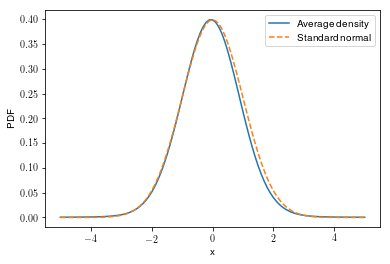

In [53]:
mean_density = distributions.mean(axis = 0)
plt.plot(x, mean_density*gaussian(x, 0, 1).max()/mean_density.max(), label = 'Average density')
plt.plot(x, gaussian(x, 0, 1), '--', label = 'Standard normal')
plt.xlabel('x')
plt.ylabel('PDF')
plt.legend()
plt.show()

## 3. Posterior Distribution

Take a look at the posterior distribution of the parameters:

In [54]:
df = pd.DataFrame(parameters)
df.columns = ['w', 'mu_1', 'mu_2', 'lambda', 'd_mean']
df.describe()

,w,mu_1,mu_2,lambda,d_mean
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.484062,-0.140020,-0.123002,1.268311,1.516139
std,0.365845,2.812966,2.518976,0.225470,0.371578
min,0.000001,-43.134734,-35.698652,0.012616,1.000000
25%,0.101566,-0.349518,-0.319810,1.110281,1.130000
50%,0.467761,-0.056442,-0.060899,1.242628,1.530000
75%,0.865416,0.160541,0.130034,1.398729,1.910000
max,0.999994,39.466774,36.365747,2.901596,2.000000


Posterior density of w: we can see that the weight function is more concentrated at the two ends of (0 or 1)

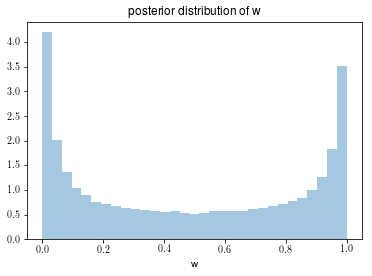

In [55]:
sns.distplot(df['w'], kde=False, norm_hist=True)
plt.title('posterior distribution of w')
plt.xlabel('w')
plt.show()

posterior distribution of $\mu_1$ and $\mu_2$:

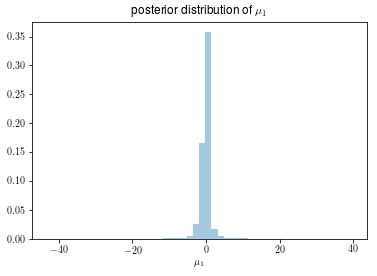

In [56]:
sns.distplot(df['mu_1'], kde=False, norm_hist=True)
plt.title(r'posterior distribution of \mu_1')
plt.xlabel(r'\mu_1')
plt.show()

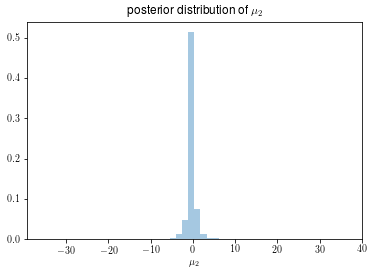

In [57]:
sns.distplot(df['mu_2'], kde=False, norm_hist=True)
plt.title(r'posterior distribution of \mu_2')
plt.xlabel(r'\mu_2')
plt.show()

We can see that the mean of both cluster are centered at 0.

Now have a look at the posterior distribution of $\lambda$:

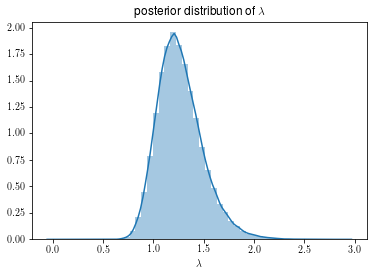

In [58]:
sns.distplot(df['lambda'])
plt.title(r'posterior distribution of \lambda')
plt.xlabel(r'\lambda')
plt.show()

From the following table we can see that the mean and median of both $\mu_1 and \ \mu_2$ are close to 0. Besides the standard deviation are a little higher than 1. The mean of $\lambda$ is 1. This indicates that both clusters are similar to a standard normal, thus the mixture of the two is also, a standard normal.

## 4. latent variable distribution

Now consider $d_i$. Even though it is a label of 1 or 2, we can take the average of $d_i$'s at each iteration and have an idea of the fraction of samples coming from each cluster. When the average of $d_i$'s is close to 1, most of samples come from the 1 cluster, vice versa. This histogram is consistent with the histogram of w. 

Even though the latent variable is more likely to take all 1's or all 2's than mixed 1 and 2, this indicates that data are coming from one group. Also the two groups are similar to each other, i.e. a standard normal.

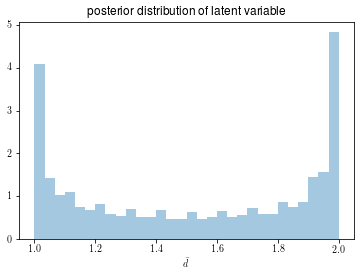

In [59]:
sns.distplot(df.d_mean, kde=False, norm_hist=True)
plt.title('posterior distribution of latent variable')
plt.xlabel(r'\bar{d}')
plt.show()

## 5.
Now use the samples take during from each iteration of the Markov chain to estimate the integral:

In [60]:
sample5.mean()

-0.055029621209702999

The MC estimation of the integral is -0.055 which is close to 0. To help visualize this, I also plotted the histogram of the samples taken from Gibbs sampler. The distribution of the samples also looks like a standard normal.

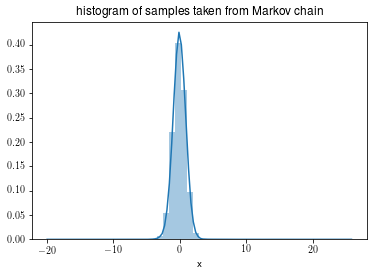

In [61]:
sns.distplot(sample5)
plt.title('histogram of samples taken from Markov chain')
plt.xlabel('x')
plt.show()

## 6.

Take the average of $w\mu_1 + (1-w) \mu_2$ from the Markov chain, the result is -0.0569. This is also close to the real mean 0.

In [62]:
(df['w'] * df['mu_1'] + (1-df['w']) * df['mu_2']).mean()

-0.05687848692397762

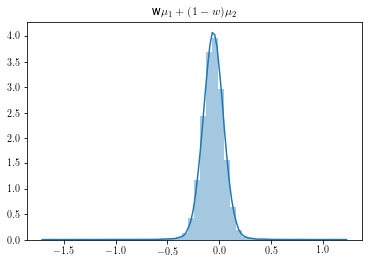

In [63]:
sns.distplot(df['w'] * df['mu_1'] + (1-df['w']) * df['mu_2'])
plt.title(r'w\mu_1 + (1-w) \mu_2')
plt.show()

Thus both 5 and 6 give the correct estimate to the integration. As discussed in class, there are two ways to estimate MC integration from $\theta^1, ..., \theta^m$:

1. take $x^m$ from $g(x|\theta^m)$ and take the mean of $x^m$, which is what I did in question 5.
2. take the average predictive density $\hat{g}_p$ and estimate $I$ by $\hat{I} = \int h(x) \hat{g}_p dx$. Since the $h(x) = x$ in this homework. This is actual what we are asked to do in question 6.

Thus both methods give the correct answer.

However, note that if we first take the average of $w, \mu_1, \mu_2$ and then compute $w\mu_1 + (1-w) \mu_2$, the result is -0.131 which is further from 0. It is not further way because in our problem, both cluster has a mean that is close to 0. This is the intuitive but wrong way to do MC estimation for Gaussian mixture model.

In [64]:
(df['w'].mean() * df['mu_1'].mean() + (1-df['w']).mean() * df['mu_2'].mean())

-0.13123974982865413